**Here I have used a sample dataset called car_rental_feedback_dataset which is uploaded in the MyDrive section under the drive folder here**


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import time
from transformers import pipeline, AutoModelForSeq2SeqLM, AutoTokenizer

In [2]:
# ---------------------------
# Load Dataset
# ---------------------------
df = pd.read_csv('/content/drive/MyDrive/car_rental_feedback_dataset.csv')
print(df.head())

  Customer Name     Location   Car Type  \
0         Emily  Los Angeles      Sedan   
1         Rahul      Phoenix  Hatchback   
2         Rahul      Phoenix      Truck   
3           Liu      Phoenix  Hatchback   
4          Omar     New York        SUV   

                                            Review  Identified Issue Sentiment  
0   The car arrived late and caused inconvenience.     Late delivery  Negative  
1   The car arrived late and caused inconvenience.     Late delivery  Negative  
2  Had to wait a long time before getting the car.    Long wait time  Negative  
3          The staff was not courteous or helpful.  Unfriendly staff  Negative  
4           The staff was very helpful and polite.     Helpful staff  Positive  


In [3]:
# ---------------------------
# Sentiment Classification (RoBERTa)
# ---------------------------
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")

def analyze_sentiment(review):
    try:
        result = sentiment_pipeline(review)[0]['label']
        if result == 'LABEL_0':
            return 'Negative'
        elif result == 'LABEL_1':
            return 'Neutral'
        elif result == 'LABEL_2':
            return 'Positive'
        else:
            return 'Unknown'
    except Exception as e:
        print(f"Error in sentiment: {e}")
        return 'Error'

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cpu


In [4]:
# ---------------------------
# Key Phrase Extraction (FLAN-T5 Prompt Based)
# ---------------------------
print("Loading FLAN-T5-small...")
t5_model_id = "google/flan-t5-small"
tokenizer = AutoTokenizer.from_pretrained(t5_model_id)
model = AutoModelForSeq2SeqLM.from_pretrained(t5_model_id)

def extract_issue(review):
    prompt = f"Extract the main issue or praise from this car rental review in 1 short phrase:\n\"{review}\""
    try:
        inputs = tokenizer(prompt, return_tensors="pt")
        outputs = model.generate(**inputs, max_new_tokens=20)
        decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
        return decoded.strip()
    except Exception as e:
        print(f"Error in issue extraction: {e}")
        return "General Feedback"

Loading FLAN-T5-small...


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [5]:
# ---------------------------
# Run Analysis
# ---------------------------
predicted_sentiments = []
extracted_issues = []

for review in df['Review']:
    sentiment = analyze_sentiment(review)
    predicted_sentiments.append(sentiment)

    issue = extract_issue(review)
    extracted_issues.append(issue)

# Add to DataFrame
df['Predicted Sentiment'] = predicted_sentiments
df['Extracted Issue'] = extracted_issues

# Save CSVs
df[['Review', 'Predicted Sentiment']].to_csv("sentiment_results.csv", index=False)
df[['Review', 'Extracted Issue']].to_csv("issue_results.csv", index=False)

In [6]:
# Summary
print("\nSentiment Summary:\n", df['Predicted Sentiment'].value_counts())
print("\nTop Mentioned Issues:\n", df['Extracted Issue'].value_counts().head(10))


Sentiment Summary:
 Predicted Sentiment
Positive    48
Negative    44
Neutral      8
Name: count, dtype: int64

Top Mentioned Issues:
 Extracted Issue
The vehicle was not in good condition.                            14
The car was clean and well-maintained.                            14
The staff was rude and rude.                                      13
The booking process was easy and hassle-free.                     11
This is a great rental for a family.                              11
I'm not sure if it's worth it or not.                              9
The car was not working and the driver was not able to get it.     8
The prices were higher than quoted.                                8
The staff was very helpful and polite.                             7
The service was excellent and the food was delicious.              5
Name: count, dtype: int64


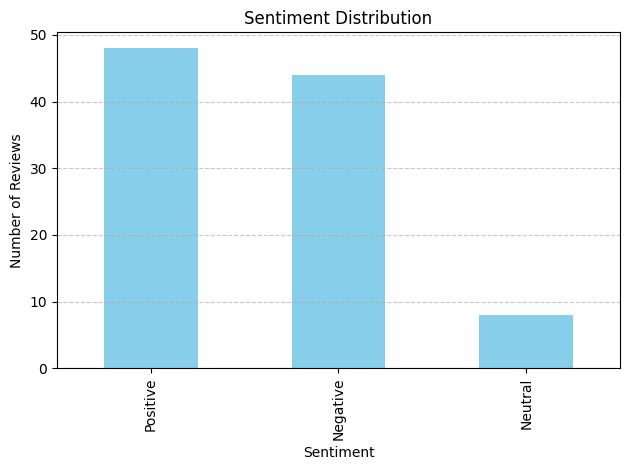

In [7]:
# Visualization of the predicted sentiment
df['Predicted Sentiment'].value_counts().plot(kind='bar', title='Sentiment Distribution', color='skyblue')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

/tmp/ipython-input-8-1487027242.py:6: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


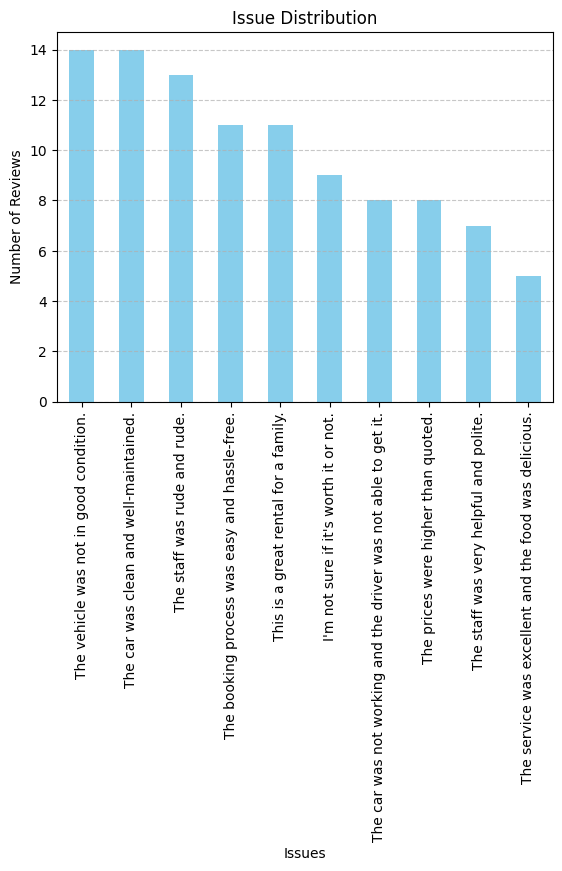

In [8]:
# Visualization of the predicted issues
df['Extracted Issue'].value_counts().plot(kind='bar', title='Issue Distribution', color='skyblue')
plt.xlabel('Issues')
plt.ylabel('Number of Reviews')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()